设备： cuda:0
数据集加载完成：10000 个样本，10 个类别
类别映射：{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=980, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
val result: 
 Accuracy: 99.3%, Avg loss: 0.025103
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1133    0    0    0    0    0    1    1    0]
 [   1    0 1026    0    0    0    0    4    1    0]
 [   0    0    1 1005    0    2    0    1    1    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   2    0    0    3    0  885    1    0    1    0]
 [   4    1    0    0    1

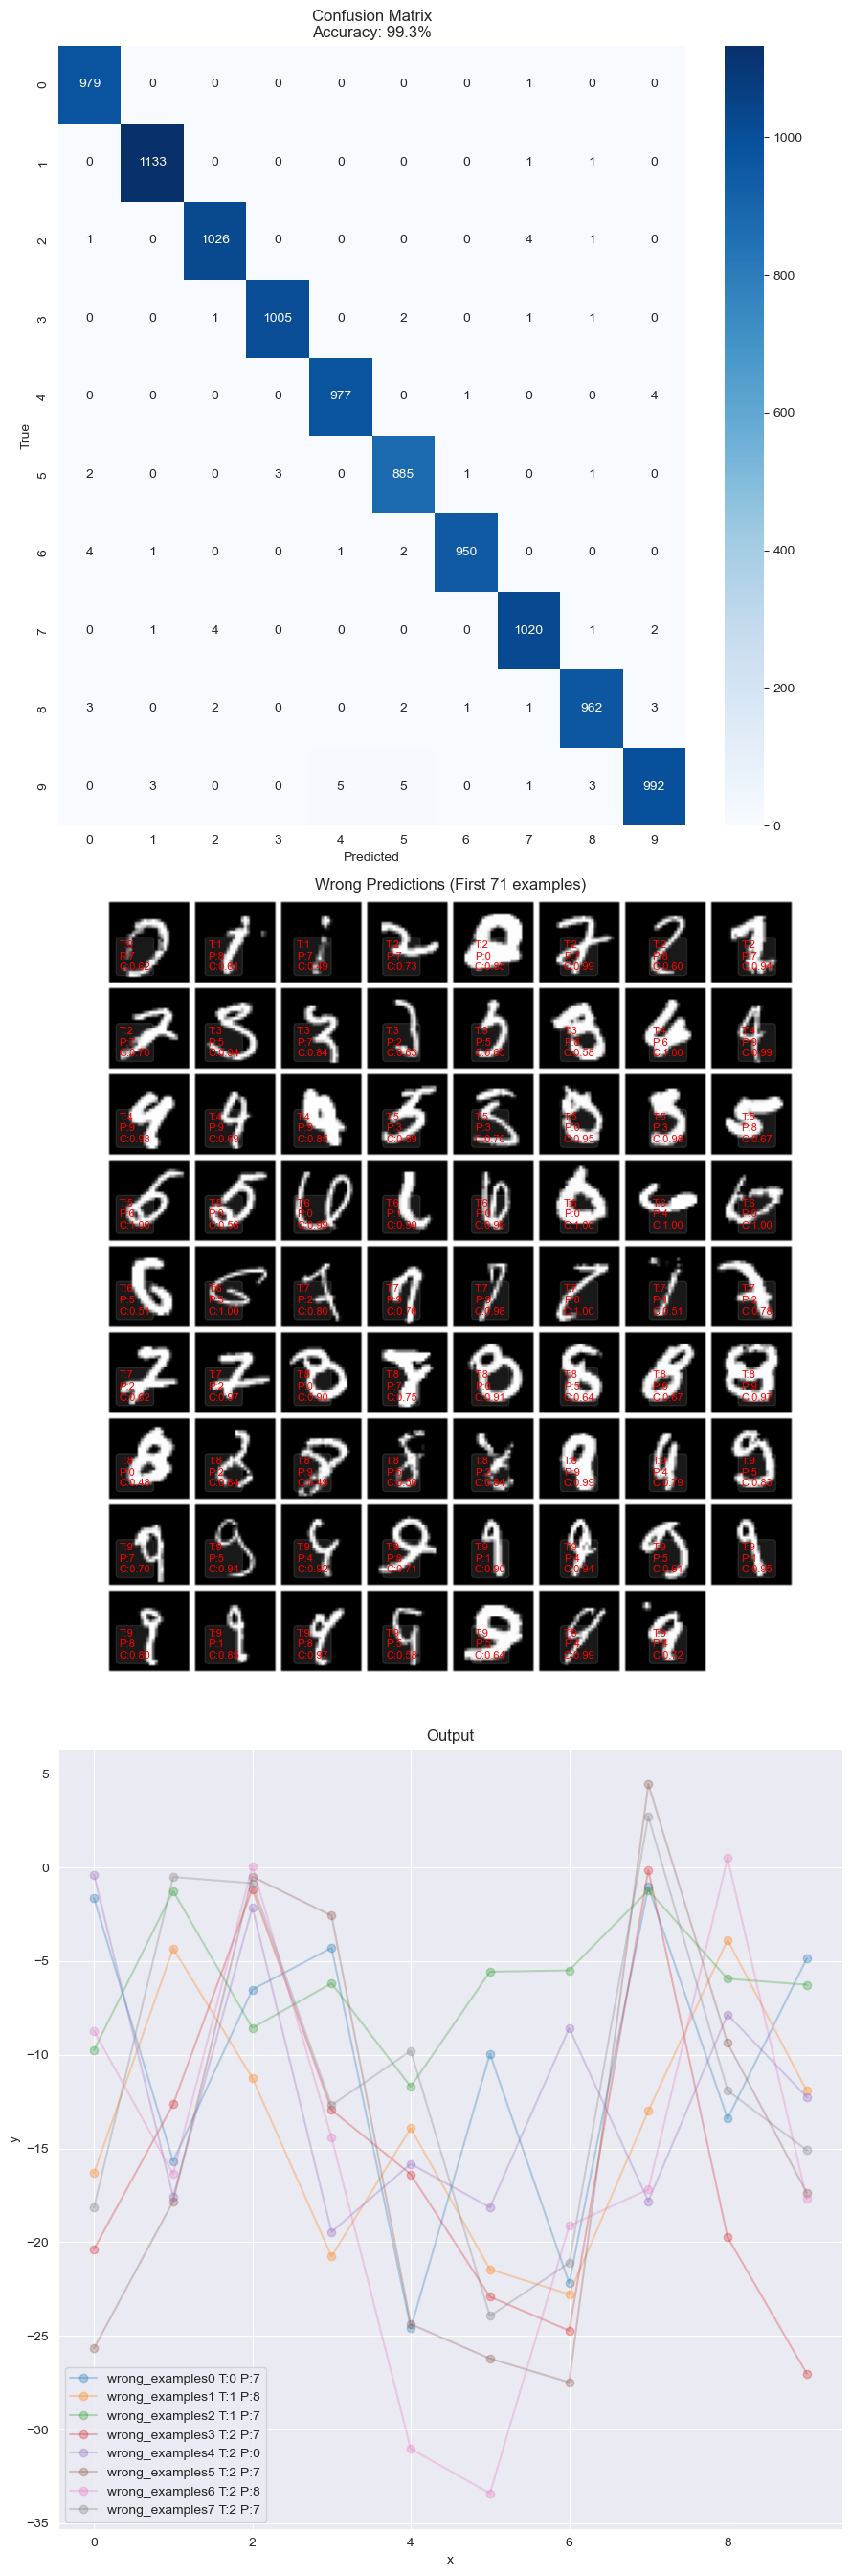


=== Detailed Analysis ===
Total samples: 10000
Correct predictions: 9929
Wrong predictions: 71

=== First 71 Wrong Predictions ===
Example 1: True=0, Pred=7, Confidence=0.617
Example 2: True=1, Pred=8, Confidence=0.611
Example 3: True=1, Pred=7, Confidence=0.495
Example 4: True=2, Pred=7, Confidence=0.732
Example 5: True=2, Pred=0, Confidence=0.850
Example 6: True=2, Pred=7, Confidence=0.992
Example 7: True=2, Pred=8, Confidence=0.603
Example 8: True=2, Pred=7, Confidence=0.936
Example 9: True=2, Pred=7, Confidence=0.699
Example 10: True=3, Pred=5, Confidence=0.945
Example 11: True=3, Pred=7, Confidence=0.837
Example 12: True=3, Pred=2, Confidence=0.625
Example 13: True=3, Pred=5, Confidence=0.653
Example 14: True=3, Pred=8, Confidence=0.578
Example 15: True=4, Pred=6, Confidence=0.999
Example 16: True=4, Pred=9, Confidence=0.985
Example 17: True=4, Pred=9, Confidence=0.984
Example 18: True=4, Pred=9, Confidence=0.686
Example 19: True=4, Pred=9, Confidence=0.850
Example 20: True=5, Pr

In [3]:
import torch
import os
import io
import zipfile
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.utils import make_grid


def setup_device():
    """设置设备配置"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("设备：", device)
    return device


class MyDataset(Dataset):
    def __init__(self, zip_path, transform=None, preload_to_memory=True):
        self.zip_path = zip_path
        self.transform = transform
        self.preload_to_memory = preload_to_memory

        # 初始化数据结构
        self.samples = []
        self.labels_set = set()
        self.images = [] if preload_to_memory else None
        self.zip_file = None

        # 打开ZIP文件
        self.zip_file = zipfile.ZipFile(zip_path, 'r')

        # 获取ZIP文件中的所有BMP文件
        bmp_files = [f for f in self.zip_file.namelist()
                    if f.lower().endswith('.bmp') and not f.endswith('/')]

        # 第一步：收集所有文件信息和标签
        file_info = []
        for img_path in bmp_files:
            img_name = os.path.basename(img_path)
            # 根据你的文件命名规则提取标签
            # 例如：对于 "0_0.bmp"，提取第一个字符 "0" 作为标签
            first_char = img_name[0]  # 提取文件名第一个字符作为标签
            file_info.append((img_path, first_char))
            self.labels_set.add(first_char)

        # 建立标签映射
        self.classes = sorted(list(self.labels_set))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_class = {i: cls_name for cls_name, i in self.class_to_idx.items()}

        # 第二步：根据预加载选项构建样本
        if preload_to_memory:
            self.images = []
            for img_path, label in file_info:
                # 从ZIP文件中读取图像
                with self.zip_file.open(img_path) as f:
                    image_data = f.read()
                    image = Image.open(io.BytesIO(image_data)).convert('L')
                    self.images.append(image)
                    label_idx = self.class_to_idx[label]
                    self.samples.append((len(self.images) - 1, label_idx))
        else:
            for img_path, label in file_info:
                label_idx = self.class_to_idx[label]
                self.samples.append((img_path, label_idx))

        print(f"数据集加载完成：{len(self.samples)} 个样本，{len(self.classes)} 个类别")
        print(f"类别映射：{self.class_to_idx}")

    def __getitem__(self, idx):
        if self.preload_to_memory:
            img_idx, label_idx = self.samples[idx]
            image = self.images[img_idx]
        else:
            img_path, label_idx = self.samples[idx]
            # 从ZIP文件中读取图像
            with self.zip_file.open(img_path) as f:
                image_data = f.read()
                image = Image.open(io.BytesIO(image_data)).convert('L')

        if self.transform:
            image = self.transform(image)
        return image, label_idx

    def __len__(self):
        return len(self.samples)

    def get_original_label(self, idx):
        _, label_idx = self.samples[idx]
        return self.idx_to_class.get(label_idx)

    def close(self):
        """关闭ZIP文件"""
        if self.zip_file:
            self.zip_file.close()

    def __del__(self):
        """析构函数，确保ZIP文件被关闭"""
        self.close()


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=2,dilation=2)
        self.bn1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        self.bn2= nn.BatchNorm2d(20)

        self.fc1 = nn.Linear(20 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #x = torch.relu(self.conv1(x))
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        # x = torch.relu(self.conv2(x))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 20 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def val(dataloader, model, loss_fn, device, class_names=None, num_wrong_examples=10, save_fig=False):
    """
    增强版验证函数，包含可视化评估
    Args:
        dataloader: 数据加载器
        model: 模型
        loss_fn: 损失函数
        device: 设备
        class_names: 类别名称列表
        num_wrong_examples: 显示的错误分类样本数量
        save_fig: 是否保存图片
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    # 初始化存储变量
    test_loss, correct = 0, 0
    all_preds = []
    all_targets = []
    wrong_examples = []  # 存储错误分类的样本
    model_outputs = []  # 存储模型最终输出

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            final_output = output

            test_loss += loss_fn(output, target).item()

            # 预测结果
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # 收集所有预测和真实标签
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # 收集模型最终输出
            model_outputs.extend(final_output.cpu().numpy())


            # 找出错误分类的样本
            wrong_mask = ~pred.eq(target.view_as(pred)).squeeze()
            if wrong_mask.any():
                wrong_indices = torch.where(wrong_mask)[0]
                for idx in wrong_indices:
                    if len(wrong_examples) < num_wrong_examples:
                        wrong_examples.append({
                            'image': data[idx].cpu(),
                            'true_label': target[idx].cpu().item(),
                            'pred_label': pred[idx].cpu().item(),
                            'confidence': torch.softmax(output[idx], dim=0).max().item(),

                            'final_output': final_output[idx].cpu().numpy()
                        })

    # 计算指标
    test_loss /= num_batches
    accuracy = 100. * correct / size

    print(f"val result: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")

    # 转换为numpy数组
    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets)
    model_outputs = np.array(model_outputs)

    # 可视化部分
    visualize_results(all_preds, all_targets, wrong_examples, model_outputs,
                     class_names, accuracy, test_loss, save_fig)

    return accuracy, test_loss, wrong_examples

def visualize_results(predictions, targets, wrong_examples, model_outputs,
                     class_names, accuracy, loss, save_fig=False):
    """
    可视化评估结果
    """
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(targets)))]

    # 1. 混淆矩阵
    plt.figure(figsize=(9, 27))

    plt.subplot(3, 1, 1)
    cm = confusion_matrix(targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.1f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    print(cm)


    # 2. 错误分类样本展示
    plt.subplot(3, 1, 2)
    if wrong_examples:
        # 准备显示的图像网格
        wrong_images = [example['image'] for example in wrong_examples]
        wrong_grid = make_grid(wrong_images, nrow=8, normalize=True, pad_value=1)

        # 显示图像
        wrong_grid_np = wrong_grid.numpy().transpose((1, 2, 0))
        plt.imshow(wrong_grid_np)
        plt.axis('off')
        plt.title(f'Wrong Predictions (First {len(wrong_examples)} examples)')

        # 添加标签信息
        for i, example in enumerate(wrong_examples):
            row = i // 8
            col = i % 8
            true_label = class_names[example['true_label']]
            pred_label = class_names[example['pred_label']]
            conf = example['confidence']
            plt.text(col * 31 + 5, row * 30 + 25,
                    f'T:{true_label}\nP:{pred_label}\nC:{conf:.2f}',
                    fontsize=8, color='red', weight='light',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.1))
    else:
        plt.text(0.5, 0.5, 'No Wrong Predictions!',
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.axis('off')



    # 3. 最后一层输出分布（前3个例子）
    plt.subplot(3, 1, 3)
    if len(wrong_examples) > 0:
        for i, example in enumerate(wrong_examples[:8]):
            print(example['final_output'])
            plt.plot( range(len(example['final_output'])) ,example['final_output'], alpha=0.3, marker='o',
                    label=f'wrong_examples{i} T:{wrong_examples[i]['true_label']} P:{wrong_examples[i]['pred_label']}')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Output')
        plt.legend()

    plt.tight_layout()

    if save_fig:
        plt.savefig('validation_results.png', dpi=300, bbox_inches='tight')

    plt.show()

    # 打印详细统计信息
    print("\n=== Detailed Analysis ===")
    print(f"Total samples: {len(targets)}")
    print(f"Correct predictions: {np.sum(predictions == targets)}")
    print(f"Wrong predictions: {np.sum(predictions != targets)}")

    # 打印错误分类的详细信息
    if wrong_examples:
        print(f"\n=== First {len(wrong_examples)} Wrong Predictions ===")
        for i, example in enumerate(wrong_examples):
            print(f"Example {i+1}: True={class_names[example['true_label']]}, "
                  f"Pred={class_names[example['pred_label']]}, "
                  f"Confidence={example['confidence']:.3f}")



def main():
    # 设备设置
    device = setup_device()
    torch.manual_seed(42)
    num_workers = 0 # 统一设置工作进程数（必须=0）

    # 数据变换
    transform = transforms.Compose([
        #transforms.Resize((28, 28)),
        #transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # 创建数据集和数据加载器（一次性创建）
    test_dataset = MyDataset('data/1-Digit-TestSet.zip', transform=transform)

    #print(f"测试集大小: {len(test_dataset)}")
    #print(f"所有标签: {test_dataset.classes}")
    #print(f"标签映射: {test_dataset.class_to_idx}")

    # 创建数据加载器
    val_loader = DataLoader(
        test_dataset,
        batch_size=1000,
        shuffle=False,  # 测试集通常不需要shuffle
        pin_memory=True,
        #prefetch_factor=2,#单线程不可用
        num_workers=num_workers
    )

    # 模型创建和训练
    '''从文件加载模型'''


    # Model and version
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load("models/model_20251112_202325_epoch_10.pt", map_location="cuda"))  # 加载预训练权重
    model.eval()  # 设置为评估模式
    print(model)
    loss_fn = nn.CrossEntropyLoss()
    # 类别名称（根据你的数据集调整）
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    # 运行增强验证
    accuracy, loss, wrong_examples = val(val_loader, model, loss_fn, device,
                                    class_names=class_names,
                                    num_wrong_examples=100,
                                    save_fig=True)



    print("测试完成!")


if __name__ == "__main__":
    main()

26个错误样本置信度>0.9，说明模型在这些样本上非常确信但预测错误，可能存在系统性偏见。

2. 主要混淆类别
数字2 ↔ 7：出现5次（例4,6,8,9,35）

数字3 ↔ 5：出现4次（例10,13,20,21,23）

数字4 ↔ 9：出现5次（例16,17,18,19,55）

数字5 ↔ 3：出现4次（例20,21,23,58）

数字6 ↔ 0：出现5次（例27,29,30,32,43）

数字9 ↔ 4：出现5次（例55,59,62,70,71）